# Imports

In [59]:
# Data analysis
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

# Spatial
import geopandas as gpd
import osmnx as ox

# Load Spatial Data

Below is a function to load the spatial data for distribution substation boundaries.

Here we are only interested in the Substation Number (ID) and it's geometry.
 
Data was downloaded from NGED's [data portal](https://connecteddata.nationalgrid.co.uk/dataset/spatial-datasets)

In [11]:
def load_geo_data(ds_geo_filepath: str):
    ds_geo = (
        gpd.read_file(ds_geo_filepath)
        .rename(columns={'NR':'Substation Number'}) # Rename NR Column
        .dissolve('Substation Number').reset_index() # Spatially merge (Dissolve) rows with the same substation number
        .filter(items=['Substation Number', 'geometry']) # Filter Columns
        .to_crs('EPSG:4326') # Convert CRS
        .set_index('Substation Number') # Set index to Substation Number
    )
    return ds_geo

In [12]:
wm_ds_geo = load_geo_data('../data/spatial/west-midlands-distribution_july_2024.gpkg')
wm_ds_geo.head()

,geometry
Substation Number,
110161,"MULTIPOLYGON (((-2.51017 51.44557, -2.50980 51..."
110163,"MULTIPOLYGON (((-2.52374 51.53600, -2.52358 51..."
110187,"POLYGON ((-2.49600 51.51523, -2.49601 51.51536..."
110200,"MULTIPOLYGON (((-2.50668 51.44981, -2.50666 51..."
110229,"MULTIPOLYGON (((-2.49112 51.52825, -2.49102 51..."


In [23]:
wm_ds_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55278 entries, 110161 to 946355
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  55278 non-null  geometry
dtypes: geometry(1)
memory usage: 2.9+ MB


# Load LCT Data

Here we load data for secondary distribution substations from NGED's [data portal](https://connecteddata.nationalgrid.co.uk/dataset/distribution-substations). 

This includes information about LCT connections, the number of customers and the exact location of the distribution substation.

In [17]:
def load_lct_data(filepath: str):
    df = (
        pd.read_csv(filepath)
        .replace('Hidden', np.nan)
        .astype({'Customers':'float64', 'Substation Number':'Int64'})
        .astype({'Substation Number': str})
    )
    return df

In [18]:
lct_df = load_lct_data('../data/lct/distribution-substations_july_2024.csv')
lct_df.set_index('Substation Number', inplace=True)
lct_df.head()

,Licence Area,Grid Supply Point Number,Grid Supply Point Name,Bulk Supply Point Number,Bulk Supply Point Name,Primary Name,Primary Number,HV Feeder,Substation Type,Substation Name,...,Total LCT Capacity,Total Generation Capacity,Wind,Bio Fuels,Water Generation,Waste Generation,Storage Generation,Fossil Fuels,Other Generation,Customers
Substation Number,,,,,,,,,,,,,,,,,,,,,
742968,West Midlands,670002.0,BISHOPS WOOD 132kV S STN,670064.0,LUDLOW 132kV S STN,Tenbury 33/11kv,750002,750002/0006,Pole Mtd Dist. Substation,NASH COURT -TRAN,...,0,3,1,0,0,0,0,0,0,16.0
742995,West Midlands,670002.0,BISHOPS WOOD 132kV S STN,670064.0,LUDLOW 132kV S STN,Tenbury 33/11kv,750002,750002/0002,Pole Mtd Dist. Substation,KNIGHTON ON TEME -TRAN,...,7,25,5,0,0,0,0,0,0,6.0
743127,West Midlands,670002.0,BISHOPS WOOD 132kV S STN,670064.0,LUDLOW 132kV S STN,Cleobury Mortimer 33/11kv,750004,750004/0006,Pole Mtd Dist. Substation,LUBBERLANDS -TRAN,...,0,36,2,0,0,0,0,0,0,7.0
743172,West Midlands,670002.0,BISHOPS WOOD 132kV S STN,670064.0,LUDLOW 132kV S STN,Cleobury Mortimer 33/11kv,750004,750004/0006,Pole Mtd Dist. Substation,PEACOCK FARM - TRAN,...,0,0,0,0,0,0,0,0,0,10.0
743275,West Midlands,670002.0,BISHOPS WOOD 132kV S STN,670013.0,HEREFORD 66kV S STN,Knighton 66/11kv,670121,670121/0001,Pole Mtd Dist. Substation,LLANFAIRWATERDINE -TRAN,...,15,13,5,0,0,0,0,0,0,20.0


In [22]:
lct_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195164 entries, 742968 to 594147
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Licence Area               195164 non-null  object 
 1   Grid Supply Point Number   194742 non-null  float64
 2   Grid Supply Point Name     194742 non-null  object 
 3   Bulk Supply Point Number   194360 non-null  float64
 4   Bulk Supply Point Name     193937 non-null  object 
 5   Primary Name               195164 non-null  object 
 6   Primary Number             195164 non-null  int64  
 7   HV Feeder                  194078 non-null  object 
 8   Substation Type            194078 non-null  object 
 9   Substation Name            195164 non-null  object 
 10  Grid Reference             194065 non-null  object 
 11  Longitude                  86189 non-null   float64
 12  Latitude                   86189 non-null   float64
 13  Day Max Demand             18

# Combine Spatial and LCT Data

Now we've loaded the spatial data for the substation boundaries and the LCT connection data, we perform a left join (maps the right-hand dataset to the left-hand dataset based on the left-hand dataset's index)

In [19]:
wm_lct = wm_ds_geo.join(lct_df)
wm_lct.head()

,geometry,Licence Area,Grid Supply Point Number,Grid Supply Point Name,Bulk Supply Point Number,Bulk Supply Point Name,Primary Name,Primary Number,HV Feeder,Substation Type,...,Total LCT Capacity,Total Generation Capacity,Wind,Bio Fuels,Water Generation,Waste Generation,Storage Generation,Fossil Fuels,Other Generation,Customers
Substation Number,,,,,,,,,,,,,,,,,,,,,
110161,"MULTIPOLYGON (((-2.51017 51.44557, -2.50980 51...",South West,106009.0,Iron Acton S.G.P.,113372.0,Feeder Road 33kv,Woodland Way,110375.0,110260/0005,Grd Mtd Dist. Substation,...,34.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
110163,"MULTIPOLYGON (((-2.52374 51.53600, -2.52358 51...",South West,106009.0,Iron Acton S.G.P.,113370.0,Lockleaze Bsp 132kv,Winterbourne,112130.0,112130/0003,Grd Mtd Dist. Substation,...,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
110187,"POLYGON ((-2.49600 51.51523, -2.49601 51.51536...",South West,106009.0,Iron Acton S.G.P.,113370.0,Lockleaze Bsp 132kv,Winterbourne,112130.0,112130/0004,Grd Mtd Dist. Substation,...,36.0,64.0,17.0,0.0,0.0,0.0,1.0,0.0,0.0,160.0
110200,"MULTIPOLYGON (((-2.50668 51.44981, -2.50666 51...",South West,106009.0,Iron Acton S.G.P.,113372.0,Feeder Road 33kv,Woodland Way,110375.0,110260/0005,Grd Mtd Dist. Substation,...,7.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0
110229,"MULTIPOLYGON (((-2.49112 51.52825, -2.49102 51...",South West,106009.0,Iron Acton S.G.P.,113370.0,Lockleaze Bsp 132kv,Winterbourne,112130.0,112130/0003,Grd Mtd Dist. Substation,...,47.0,41.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0


In [20]:
wm_lct.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55278 entries, 110161 to 946355
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   55278 non-null  geometry
 1   Licence Area               53402 non-null  object  
 2   Grid Supply Point Number   53202 non-null  float64 
 3   Grid Supply Point Name     53202 non-null  object  
 4   Bulk Supply Point Number   52731 non-null  float64 
 5   Bulk Supply Point Name     52731 non-null  object  
 6   Primary Name               53402 non-null  object  
 7   Primary Number             53402 non-null  float64 
 8   HV Feeder                  53402 non-null  object  
 9   Substation Type            53402 non-null  object  
 10  Substation Name            53402 non-null  object  
 11  Grid Reference             53391 non-null  object  
 12  Longitude                  25663 non-null  float64 
 13  Latitude              

We have successfuly joined these two datasets as shown by the lift of columns below:

In [34]:
wm_lct.columns

Index(['geometry', 'Licence Area', 'Grid Supply Point Number',
       'Grid Supply Point Name', 'Bulk Supply Point Number',
       'Bulk Supply Point Name', 'Primary Name', 'Primary Number', 'HV Feeder',
       'Substation Type', 'Substation Name', 'Grid Reference', 'Longitude',
       'Latitude', 'Day Max Demand', 'Night Max Demand', 'Substation Rating',
       'Transformer Headroom', 'LCT Count Total', 'Energy Storage',
       'Heat Pumps', 'EV Chargers', 'Total LCT Capacity',
       'Total Generation Capacity', 'Wind', 'Bio Fuels', 'Water Generation',
       'Waste Generation', 'Storage Generation', 'Fossil Fuels',
       'Other Generation', 'Customers'],
      dtype='object')

# Store Substation Locations as GeoPandas Geometry

Since the substation locations are split into longitute and latitude, we must combine these and store them as a geopandas data type using the `points_from_xy()` method.

In [35]:
wm_lct['Location'] = gpd.points_from_xy(wm_lct.Longitude, wm_lct.Latitude)

# Filter Data for City of Interest

We now use OSMNX (`ox`) to return geopandas geometries of any desiired town, city or region.

In [31]:
def return_geo(place):
    return ox.geocoder.geocode_to_gdf(place, which_result=1)

Here, we use the city of Birmingham (UK) as an example.

<Axes: >

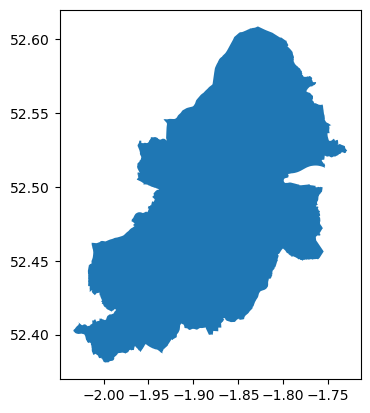

In [32]:
place = "Birmingham"
birmingham_geo = return_geo(place)
birmingham_geo.plot()

Now we can filter our combined LCT connection data based on this Birmingham boundary.

In [47]:
def filter_data_by_geo(data, geo):
    # Assuming data and geo are GeoDataFrames
    geo_boundary = geo.geometry.values[0]

    # First condition: Location within the geo boundary
    condition_within = data.Location.within(geo_boundary)

    # Second condition: Intersection is not empty
    condition_intersects = ~data.Location.intersection(geo_boundary).is_empty

    # Combine conditions using the bitwise OR operator
    filtered_data = data.loc[condition_within | condition_intersects]

    return filtered_data

In [48]:
birmingham_lct = filter_data_by_geo(wm_lct, birmingham_geo)
birmingham_lct.head()

,geometry,Licence Area,Grid Supply Point Number,Grid Supply Point Name,Bulk Supply Point Number,Bulk Supply Point Name,Primary Name,Primary Number,HV Feeder,Substation Type,...,Total Generation Capacity,Wind,Bio Fuels,Water Generation,Waste Generation,Storage Generation,Fossil Fuels,Other Generation,Customers,Location
Substation Number,,,,,,,,,,,,,,,,,,,,,
720005,"POLYGON ((-1.98904 52.40575, -1.98929 52.40593...",West Midlands,670011.0,KITWELL 132kV S STN,670049.0,LONGBRIDGE 132kV S STN,Longbridge 132/11kvdummy,670049.0,670049/0031,Grd Mtd Dist. Substation,...,21.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,326.0,POINT (-1.98460 52.40780)
720021,"POLYGON ((-1.94935 52.39244, -1.94928 52.39294...",West Midlands,670011.0,KITWELL 132kV S STN,670049.0,LONGBRIDGE 132kV S STN,Longbridge 132/11kvdummy,670049.0,670049/0037,Grd Mtd Dist. Substation,...,38.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,344.0,POINT (-1.94530 52.39280)
720030,"POLYGON ((-1.84987 52.41378, -1.84994 52.41374...",West Midlands,670011.0,KITWELL 132kV S STN,670061.0,HIGHTERS HEATH 132kV S STN,Highters Heath 132/11kvdummy,670061.0,670061/0010,Grd Mtd Dist. Substation,...,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,367.0,POINT (-1.84500 52.41480)
720037,"POLYGON ((-1.97249 52.40334, -1.97242 52.40341...",West Midlands,670011.0,KITWELL 132kV S STN,670049.0,LONGBRIDGE 132kV S STN,Longbridge 132/11kvdummy,670049.0,670049/0046,Grd Mtd Dist. Substation,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,370.0,POINT (-1.96816 52.40390)
720038,"POLYGON ((-1.99805 52.40883, -1.99805 52.40890...",West Midlands,670011.0,KITWELL 132kV S STN,670049.0,LONGBRIDGE 132kV S STN,Longbridge 132/11kvdummy,670049.0,670049/0035,Grd Mtd Dist. Substation,...,30.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,283.0,POINT (-1.99443 52.40914)


# Plot LCTs

We can now plot the LCT Connection (e.g. Heat Pumps and EV Chargers) for Birmingham.

In [61]:
def plot_geodataframe(gdf, column, crs=25832, cmap='Blues', title='Map', 
                      colorbar_label='Value', output_file=None, figsize=(10, 5)):
    """
    Plots a GeoDataFrame with the specified column and other settings.

    Parameters:
    - gdf: GeoDataFrame to plot
    - column: Column to use for coloring
    - crs: Coordinate Reference System to project the geometries (default: 25832)
    - cmap: Colormap to use (default: 'Blues')
    - title: Title of the plot (default: 'Map')
    - colorbar_label: Label for the colorbar (default: 'Value')
    - output_file: Path to save the plot (default: None, doesn't save)
    - figsize: Figure size (default: (10, 5))
    """
    
    fig, ax = plt.subplots(figsize=figsize)

    # Define colormap and normalization instance
    min_value = gdf[column].min()
    max_value = gdf[column].max()
    norm = colors.Normalize(vmin=min_value, vmax=max_value)

    # Plot GeoDataFrame
    gdf.to_crs(crs).plot(
        ax=ax,
        column=column,
        legend=False,
        missing_kwds=dict(color="lightgrey"),
        cmap=cmap,
        norm=norm,
        linewidth=0.05
    )
    
    # Remove axis ticks and labels
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
    
    # Add scale bar
    ax.add_artist(ScaleBar(1, length_fraction=0.3, location='upper left'))
    
    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(mappable, cax=cax, orientation='vertical')
    cbar.set_label(colorbar_label)

    # Set title
    ax.set_title(title, fontsize=12)
    
    # Save plot if output_file is specified
    if output_file:
        plt.savefig(output_file, bbox_inches="tight", pad_inches=0.2, dpi=800)
    
    # Show plot
    plt.show()


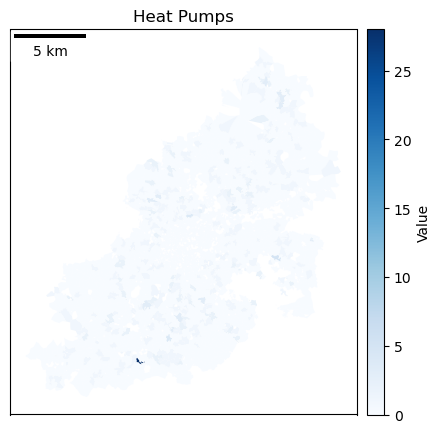

In [64]:
plot_geodataframe(gdf=birmingham_lct, column='Heat Pumps', title='Heat Pumps', output_file=False)

Let's inspect the very high count of Heat Pump installations.

In [57]:
birmingham_lct['Heat Pumps'].sort_values(ascending=False)

Substation Number
720451    28.0
723016     5.0
721721     4.0
721708     4.0
723699     3.0
          ... 
722471     0.0
722469     0.0
722467     0.0
722466     0.0
734835     0.0
Name: Heat Pumps, Length: 2117, dtype: float64

One distribution substation has 28 heat pumps installed! We can do the same for EV chargers

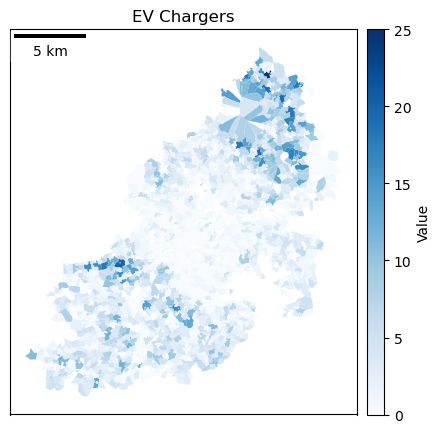

In [65]:
plot_geodataframe(gdf=birmingham_lct, column='EV Chargers', title='EV Chargers', output_file=False)